# **What pricing strategies can we implement to maximize revenue?**
- Analyze price elasticity for different product categories.
- Develop a dynamic pricing model based on demand and competition.


#### **Importing packages and loading data**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


In [2]:
products_df = pd.read_pickle('Outputs/products.pkl')
merged_df = pd.read_pickle('Outputs/orders.pkl')
daily_sales = pd.read_pickle('Outputs/daily_sales.pkl')
daily_sales_by_main_category = pd.read_pickle('Outputs/daily_sales_by_main_category.pkl')
daily_sales_by_sub_category = pd.read_pickle('Outputs/daily_sales_by_sub_category.pkl')

#### **Data Preperation**

In [3]:
# # Step 1: Merge the orders data with the products data on 'product_id'
# merged_df = pd.merge(orders_df, products_df, on='product_id', how='left')

# Step 2: Create the 'price' column based on whether 'campaign_name' is missing or there is campaign, use discounted price if there is promotion campaign, else if none use original price
# merged_df['price'] = merged_df.apply(
#     lambda row: row['price_actual'] if pd.notna(row['campaign_name']) else row['price_ori'],
#     axis=1
# )

#### **Calculating Price Elasticity of Demand (PED)**

Price Elasticity of Demand (PED) measures the responsiveness of quantity demanded to a change in price. The formula for PED is:

PED = (% Change in Quantity Demanded) / (% Change in Price)

Where:
- % Change in Quantity = ((New Quantity - Old Quantity) / Old Quantity) * 100
- % Change in Price = ((New Price - Old Price) / Old Price) * 100

**Interpretation**:
- A **PED > 1** indicates **elastic demand** (quantity demanded is sensitive to price changes).
- A **PED < 1** indicates **inelastic demand** (quantity demanded is less responsive to price changes).
- A **PED = 1** indicates **unitary elasticity** (proportional change in quantity and price).


In [4]:
import numpy as np
import pandas as pd

def calculate_ped(data, category_column='main_category'):
    """
    Calculates the Price Elasticity of Demand (PED) for each unique time period in a specified category column.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing sales and price data with columns 'order_time', 'avg_checkout_price', and 'daily_sales'.
        category_column (str): The name of the category column to group by (e.g., 'main_category' or 'sub_category').
    
    Returns:
        pd.DataFrame: DataFrame with PED values calculated for each time period within the specified category.
    """
    # Fill missing values in 'avg_checkout_price' with 0
    data['avg_checkout_price'] = data['avg_checkout_price'].fillna(0)

    # Ensure 'order_time' is in datetime format and extract daily periods
    data['order_time'] = pd.to_datetime(data['order_time'])
    data['time_period'] = data['order_time'].dt.date

    # Sort the data by category and time_period to ensure correct ordering
    data = data.sort_values(by=[category_column, 'time_period'])

    # Calculate previous day's values for 'avg_checkout_price' and 'daily_sales' to compute % changes
    data['previous_sales'] = data.groupby(category_column)['daily_sales'].shift(1)
    data['previous_price'] = data.groupby(category_column)['avg_checkout_price'].shift(1)

    # Calculate % change in quantity (daily_sales) and % change in price (avg_checkout_price)
    data['%_change_in_sales'] = (
        (data['daily_sales'] - data['previous_sales']) / data['previous_sales'].replace({0: np.nan})
    ).fillna(0) * 100
    data['%_change_in_price'] = (
        (data['avg_checkout_price'] - data['previous_price']) / data['previous_price'].replace({0: np.nan})
    ).fillna(0) * 100

    # Calculate PED for each day within each category
    data['PED'] = data['%_change_in_sales'] / data['%_change_in_price'].replace({0: np.nan})

    # Display relevant columns
    return data

# Example usage:
# For main_category
ped_main_category = calculate_ped(daily_sales_by_main_category, 'main_category')
print(ped_main_category)

# For sub_category
ped_sub_category = calculate_ped(daily_sales_by_sub_category, 'sub_category')
print(ped_sub_category)


     main_category order_time  avg_checkout_price  avg_additional_discount  \
0       Automotive 2019-01-01            0.850155                 0.000000   
1       Automotive 2019-01-02            0.284942                 0.000000   
2       Automotive 2019-01-03            0.663930                 0.000000   
3       Automotive 2019-01-04           11.918405                 0.000000   
4       Automotive 2019-01-05            3.698537                 0.000000   
...            ...        ...                 ...                      ...   
8385  Women's Bags 2019-12-27           16.459904                 0.000000   
8386  Women's Bags 2019-12-28           24.550307                 0.000000   
8387  Women's Bags 2019-12-29           20.091368                 0.000000   
8388  Women's Bags 2019-12-30           34.725553                 0.000000   
8389  Women's Bags 2019-12-31            8.209789                53.888889   

      day_of_week  week  month  is_weekend  products_discounted

In [5]:
from sklearn.preprocessing import PowerTransformer
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.express as px
import pandas as pd
import numpy as np

def transform_ped(data, category_column):
    """
    Transforms the PED (Price Elasticity of Demand) for each unique value in a specified category column.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing the PED data with columns 'time_period' and 'PED'.
        category_column (str): The name of the column to group by (e.g., 'main_category' or 'sub_category').
    
    Returns:
        pd.DataFrame: DataFrame with the transformed PED values for each category.
    """
    power_transformer = PowerTransformer(method='yeo-johnson')
    transformed_data = pd.DataFrame()
    categories = data[category_column].unique()

    for category in categories:
        category_data = data[data[category_column] == category].copy()
        
        if category_data['PED'].notna().sum() > 0:
            ped_values = category_data['PED'].replace(np.nan, 0).values.reshape(-1, 1)
            transformed_ped = power_transformer.fit_transform(ped_values).flatten()
            category_data['transformed_PED'] = transformed_ped
        else:
            category_data['transformed_PED'] = np.nan
        
        transformed_data = pd.concat([transformed_data, category_data])

    return transformed_data

def plot_transformed_ped(transformed_data, category_column, title="Transformed PED Fluctuations"):
    """
    Plots the transformed PED fluctuations for each unique value in a specified category column.
    
    Parameters:
        transformed_data (pd.DataFrame): DataFrame containing transformed PED data with 'time_period' and 'transformed_PED'.
        category_column (str): The name of the column to group by (e.g., 'main_category' or 'sub_category').
        title (str): The title of the plot.
    """
    categories = transformed_data[category_column].unique()
    n_cols = 4
    n_rows = (len(categories) + n_cols - 1) // n_cols
    fig = sp.make_subplots(rows=n_rows, cols=n_cols, subplot_titles=categories)

    for idx, category in enumerate(categories):
        row = (idx // n_cols) + 1
        col = (idx % n_cols) + 1
        category_data = transformed_data[transformed_data[category_column] == category]
        
        fig.add_trace(
            go.Scatter(
                x=category_data['time_period'],
                y=category_data['transformed_PED'],
                mode='lines',
                name=category,
                line=dict(color=px.colors.qualitative.Plotly[idx % len(px.colors.qualitative.Plotly)])
            ),
            row=row, col=col
        )

        fig.update_xaxes(title_text="Time Period", row=row, col=col)
        fig.update_yaxes(title_text="Transformed PED", row=row, col=col)

    fig.update_layout(
        title=title,
        height=300 * n_rows,
        showlegend=False,
        template="plotly_white"
    )
    fig.show()

# Example usage:
# Transform PED for main category
transformed_main_category = transform_ped(ped_main_category, 'main_category')
plot_transformed_ped(transformed_main_category, 'main_category', title="Transformed PED Fluctuations by Main Category")

# Transform PED for sub category
transformed_sub_category = transform_ped(ped_sub_category, 'sub_category')
# plot_transformed_ped(transformed_sub_category, 'sub_category', title="Transformed PED Fluctuations by Sub Category")


In [13]:
products_df[products_df.sub_category == 'Occupational Attire'].price_ori.min()

0.4671180064649132

In [58]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Filter data for 'Occupational Attire'
occupational_data = transformed_sub_category[transformed_sub_category['sub_category'] == 'Occupational Attire'].copy()
occupational_data = transformed_main_category[transformed_main_category['main_category'] == 'Fashion Accessories'].copy()
# Set base parameters
base_price = list(occupational_data['avg_checkout_price'])[0]  # Use the average as a baseline

# Calculate improved optimal price and ideal sales
occupational_data['optimal_price'] = base_price * (1 + occupational_data['PED'] / 100)
occupational_data['price_change_factor'] = occupational_data['optimal_price'] / occupational_data['avg_checkout_price']
occupational_data['ideal_sales'] = occupational_data['daily_sales'] * occupational_data['price_change_factor']
occupational_data['actual_revenue'] = occupational_data['daily_sales'] * occupational_data['avg_checkout_price']
occupational_data['ideal_revenue'] = occupational_data['ideal_sales'] * occupational_data['optimal_price']

# Plot actual vs. ideal sales with current and optimal price
fig = go.Figure()

# Current average checkout price line
fig.add_trace(go.Scatter(
    x=occupational_data['time_period'],
    y=occupational_data['avg_checkout_price'],
    mode='lines',
    name="Current Avg Checkout Price",
    line=dict(color='purple')
))

# Improved optimal price line
fig.add_trace(go.Scatter(
    x=occupational_data['time_period'],
    y=occupational_data['optimal_price'],
    mode='lines',
    name="Improved Optimal Price",
    line=dict(color='orange', dash='dot')
))

# Update layout
fig.update_layout(
    title="Current and Improved Optimal Prices for 'Occupational Attire'",
    xaxis_title="Date",
    yaxis_title="Sales / Price",
    template="plotly_white",
    showlegend=True
)

fig.show()

fig_rev = go.Figure()

# Current average checkout price line
fig_rev.add_trace(go.Scatter(
    x=occupational_data['time_period'],
    y=np.cumsum(occupational_data['actual_revenue']),
    mode='lines',
    name="Current Cumulative Revenue",
    line=dict(color='purple')
))

# Improved optimal price line
fig_rev.add_trace(go.Scatter(
    x=occupational_data['time_period'],
    y=np.cumsum(occupational_data['ideal_revenue']),
    mode='lines',
    name="Ideal Cumulative Revenue",
    line=dict(color='orange')
))

# Update layout
fig_rev.update_layout(
    title="Current and Improved Optimal Prices for 'Occupational Attire'",
    xaxis_title="Date",
    yaxis_title="Sales / Price",
    template="plotly_white",
    showlegend=True
)

fig_rev.show()




In [48]:
occupational_data

,main_category,order_time,avg_checkout_price,avg_additional_discount,day_of_week,week,month,is_weekend,products_discounted_percentage,campaign_percentage,...,%_change_in_sales,%_change_in_price,PED,transformed_PED,Optimal_Discount,Expected_Revenue,Cumulative_Expected_Revenue,Current_Discount,Actual_Revenue,Cumulative_Actual_Revenue
time_period,,,,,,,,,,,,,,,,,,,,,
2019-01-01,Health & Beauty,2019-01-01,14.161051,0.000000,1.0,1.0,1.0,0.0,52.631579,0.0,...,0.000000,0.000000,0.000000,0.068132,0.0,269.059972,269.059972,0.180772,269.059972,269.059972
2019-01-02,Health & Beauty,2019-01-02,13.027402,0.000000,2.0,1.0,1.0,0.0,58.333333,0.0,...,26.315789,-8.005401,-3.287254,-0.066844,0.0,312.657652,581.717624,0.290305,312.657652,581.717624
2019-01-03,Health & Beauty,2019-01-03,12.401983,0.000000,3.0,1.0,1.0,0.0,50.000000,0.0,...,-33.333333,-4.800797,6.943292,0.216113,0.0,198.431729,780.149353,0.201549,198.431729,780.149353
2019-01-04,Health & Beauty,2019-01-04,9.831866,0.000000,4.0,1.0,1.0,0.0,51.351351,0.0,...,131.250000,-20.723435,-6.333409,-0.226192,0.0,363.779047,1143.928400,0.278728,363.779047,1143.928400
2019-01-05,Health & Beauty,2019-01-05,6.867258,0.000000,5.0,1.0,1.0,1.0,62.222222,0.0,...,21.621622,-30.153061,-0.717062,0.043584,0.0,27.469030,1171.397430,0.308886,309.026588,1452.954989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,Health & Beauty,2019-12-27,6.837051,0.000000,4.0,4.0,12.0,0.0,35.714286,0.0,...,154.545455,-27.275054,-5.666183,-0.189254,NaN,NaN,NaN,0.210224,191.437416,117091.347262
2019-12-28,Health & Beauty,2019-12-28,9.311664,0.000000,5.0,4.0,12.0,1.0,57.142857,0.0,...,-25.000000,36.194163,-0.690719,0.044549,NaN,NaN,NaN,0.283006,195.544940,117286.892202
2019-12-29,Health & Beauty,2019-12-29,16.598357,0.000000,6.0,4.0,12.0,1.0,53.125000,0.0,...,52.380952,78.253398,0.669376,0.087521,NaN,NaN,NaN,0.233335,531.147429,117818.039630


In [72]:
occupational_data

,main_category,order_time,avg_checkout_price,avg_additional_discount,day_of_week,week,month,is_weekend,products_discounted_percentage,campaign_percentage,avg_discount_percentage,daily_sales,previous_sales,previous_price,%_change_in_sales,%_change_in_price,PED,prophet_safety_stock,is_below_safety_stock
NaN,Fashion Accessories,2019-01-01,7.872495,0.000000,1.0,1.0,1.0,0.0,85.714286,0.0,38.653288,7,0.0,0.000000,0.000000,0.000000,0.000000,NaN,0
NaN,Fashion Accessories,2019-01-02,9.385958,0.000000,2.0,1.0,1.0,0.0,66.666667,0.0,40.063125,3,7.0,7.872495,-57.142857,19.224684,-2.972369,NaN,0
NaN,Fashion Accessories,2019-01-03,19.383840,0.000000,3.0,1.0,1.0,0.0,100.000000,0.0,62.843465,2,3.0,9.385958,-33.333333,106.519575,-0.312932,NaN,0
NaN,Fashion Accessories,2019-01-04,4.327070,0.000000,4.0,1.0,1.0,0.0,50.000000,0.0,29.611922,4,2.0,19.383840,100.000000,-77.676922,-1.287384,NaN,0
NaN,Fashion Accessories,2019-01-05,4.762824,0.000000,5.0,1.0,1.0,1.0,85.714286,0.0,42.748184,7,4.0,4.327070,75.000000,10.070426,7.447550,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,Fashion Accessories,2019-12-27,4.699207,0.000000,4.0,4.0,12.0,0.0,66.666667,0.0,33.537904,6,0.0,0.000000,0.000000,0.000000,0.000000,NaN,0
NaN,Fashion Accessories,2019-12-28,5.053772,0.000000,5.0,4.0,12.0,1.0,85.714286,0.0,42.170056,7,6.0,4.699207,16.666667,7.545205,2.208908,NaN,0
NaN,Fashion Accessories,2019-12-29,4.110638,0.000000,6.0,4.0,12.0,1.0,80.000000,0.0,30.681247,5,7.0,5.053772,-28.571429,-18.661972,1.530997,NaN,0
NaN,Fashion Accessories,2019-12-30,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0,5.0,4.110638,-100.000000,-100.000000,1.000000,NaN,0


In [75]:
occupational_data.columns

Index(['main_category', 'order_time', 'avg_checkout_price',
       'avg_additional_discount', 'day_of_week', 'week', 'month', 'is_weekend',
       'products_discounted_percentage', 'campaign_percentage',
       'avg_discount_percentage', 'daily_sales', 'previous_sales',
       'previous_price', '%_change_in_sales', '%_change_in_price', 'PED',
       'prophet_safety_stock', 'is_below_safety_stock',
       'Predicted_Discount_Rate', 'Inventory_Level'],
      dtype='object')

In [81]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

# Load historical data for 'Fashion Accessories'
occupational_data = ped_main_category[ped_main_category['main_category'] == 'Fashion Accessories'].copy()
occupational_data = occupational_data.fillna(0)
occupational_data['time_period'] = pd.to_datetime(occupational_data['time_period'])
occupational_data.set_index('time_period', inplace=True)

# Load pre-existing forecast data from Prophet
forecast = pd.read_pickle('Outputs/future_forecast.pkl')
forecast = forecast.set_index('ds')  # Make sure the index is datetime

# Step 1: Train the PED prediction model
# Features and target variable
features = occupational_data[['avg_checkout_price', 'daily_sales', 'day_of_week', 'month']]
target = occupational_data['PED']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the Random Forest model to predict PED
ped_model = RandomForestRegressor(n_estimators=100, random_state=42)
ped_model.fit(X_train, y_train)

# Evaluate the model
ped_predictions = ped_model.predict(X_test)
print("PED Model RMSE:", mean_squared_error(y_test, ped_predictions, squared=False))

# Step 2: Prepare forecast data for PED prediction
forecast['day_of_week'] = forecast.index.dayofweek
forecast['month'] = forecast.index.month
forecast['avg_checkout_price'] = occupational_data['avg_checkout_price'].mean()  # Assume current avg price

# Rename yhat to daily_sales to match training data features
forecast_features = forecast[['avg_checkout_price', 'yhat', 'day_of_week', 'month']].rename(columns={'yhat': 'daily_sales'})

forecast['predicted_PED'] = ped_model.predict(forecast_features)

# Step 3: Calculate optimal price based on predicted PED
def calculate_optimal_price(current_price, ped):
    # Adjust price based on PED to maximize revenue
    return current_price * (1 + ped / 100) if ped < 0 else current_price

forecast['optimal_price'] = forecast.apply(
    lambda row: calculate_optimal_price(row['avg_checkout_price'], row['predicted_PED']), axis=1
)
forecast['optimal_daily_sales'] = forecast['yhat'] * (1 + forecast['predicted_PED'] / 100)
forecast['optimal_revenue'] = forecast['optimal_price'] * forecast['optimal_daily_sales']

# Step 4: Calculate actual revenue and compare to optimal revenue
forecast['actual_revenue'] = forecast['yhat'] * forecast['avg_checkout_price']
forecast['cumulative_actual_revenue'] = forecast['actual_revenue'].cumsum()
forecast['cumulative_optimal_revenue'] = forecast['optimal_revenue'].cumsum()

# Plot cumulative revenue comparison
fig_revenue = go.Figure()

# Actual cumulative revenue
fig_revenue.add_trace(go.Scatter(
    x=forecast.index, y=forecast['cumulative_actual_revenue'],
    mode='lines', name="Cumulative Actual Revenue", line=dict(color='blue')
))

# Optimal cumulative revenue from optimized pricing
fig_revenue.add_trace(go.Scatter(
    x=forecast.index, y=forecast['cumulative_optimal_revenue'],
    mode='lines', name="Cumulative Optimal Revenue", line=dict(color='green')
))

fig_revenue.update_layout(
    title="Cumulative Actual vs. Optimal Revenue for 'Fashion Accessories' Over Forecasted Period",
    xaxis_title="Date",
    yaxis_title="Cumulative Revenue",
    template="plotly_white"
)
fig_revenue.show()

# Plot optimal vs current price
fig_price = go.Figure()

# Optimal Price
fig_price.add_trace(go.Scatter(
    x=forecast.index, y=forecast['optimal_price'],
    mode='lines', name="Optimal Price", line=dict(color='orange')
))

# Average Checkout Price (current)
fig_price.add_trace(go.Scatter(
    x=forecast.index, y=forecast['avg_checkout_price'],
    mode='lines', name="Average Checkout Price", line=dict(color='purple')
))

fig_price.update_layout(
    title="Optimal Price vs. Current Average Price for 'Fashion Accessories'",
    xaxis_title="Date",
    yaxis_title="Price",
    template="plotly_white"
)
fig_price.show()


PED Model RMSE: 235.9997968985127


c:\Users\MuhammadFauzan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



#### **Finding average PED of each main category**

In [ ]:

# Step 8: Group by 'main_category' and calculate the average PED for each category
average_ped_by_main_category = transformed_main_category.groupby('main_category')['PED'].mean().reset_index()

print(average_ped_by_main_category)


# Step 8: Group by 'main_category' and calculate the average PED for each category
average_ped_by_sub_category = transformed_sub_category.groupby('sub_category')['PED'].mean().reset_index()

print(average_ped_by_sub_category)

             main_category       PED
0               Automotive  0.370673
1              Baby & Toys -0.235614
2         Cameras & Drones -0.437035
3   Computer & Accessories  1.231118
4      Fashion Accessories -5.737719
5   Games, Books & Hobbies -3.260012
6        Gaming & Consoles -0.261625
7         Groceries & Pets  0.751639
8          Health & Beauty  6.094854
9            Home & Living -0.085038
10         Home Appliances -0.389390
11             Men Clothes -0.525129
12               Men Shoes  1.604682
13    Men's Bags & Wallets -0.961436
14    Mobile & Accessories  0.490724
15                  Others  0.918341
16        Sports & Outdoor -0.320545
17      Tickets & Vouchers  0.195040
18        Travel & Luggage  0.281671
19                 Watches -1.417364
20           Women Clothes -1.528883
21             Women Shoes  0.060864
22            Women's Bags -0.691508
                 sub_category       PED
0            Abdominal Binder  0.812500
1                 Accessories  0

### **Analyze price elasticity for different product categories**

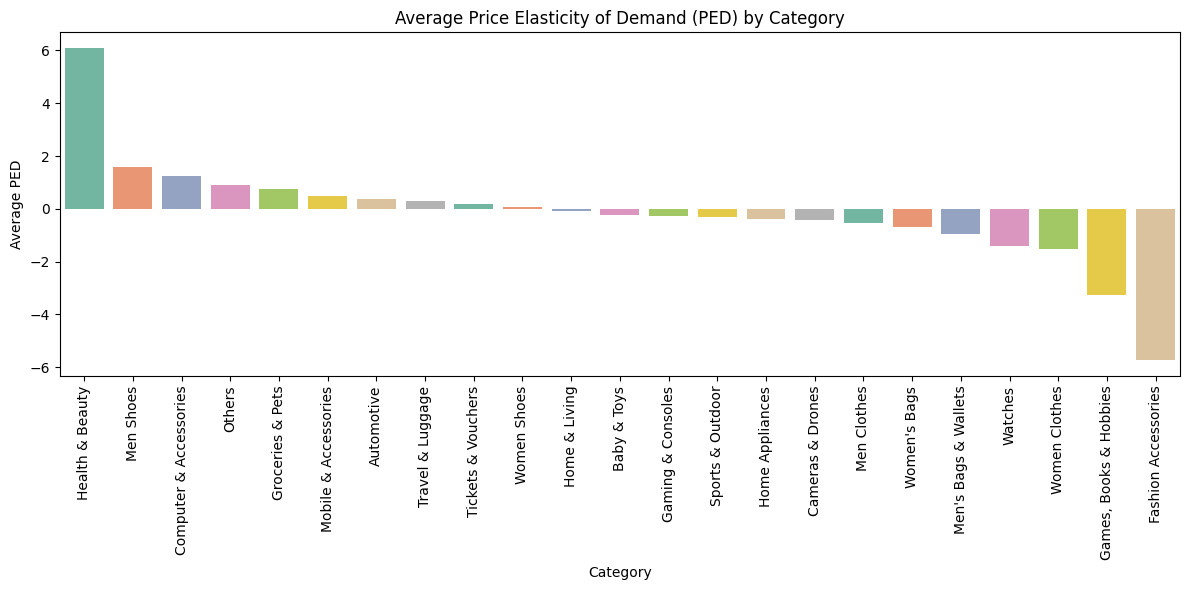

In [ ]:
average_ped_by_category = average_ped_by_main_category.sort_values(by='PED', ascending=False)

# Plotting the average PED by category to visualize price elasticity
plt.figure(figsize=(12, 6))

# Use seaborn's barplot with the DataFrame for easier handling
sns.barplot(x='main_category', y='PED', data=average_ped_by_category, hue='main_category', palette="Set2", legend=False)

plt.title("Average Price Elasticity of Demand (PED) by Category")
plt.xlabel("Category")
plt.ylabel("Average PED")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to avoid clipping of labels
plt.show()


### **Analysis of Price Elasticity of Demand (PED) Across Categories**

From the data, we see that PED varies significantly across categories, indicating that customers have different levels of price sensitivity depending on the type of product. Here’s a breakdown:

1. **Highly Elastic Categories (High PED Values)**  
   - **Computer & Accessories** (PED ~4.02) and **Tickets & Vouchers** (PED ~3.79) are the most price-sensitive categories. This high elasticity suggests that customers in these categories are very responsive to price changes. Small discounts can lead to substantial increases in demand, making these categories prime candidates for discount-based promotions.
   - Other categories with high PED include **Men Shoes** (PED ~3.21) and **Games, Books & Hobbies** (PED ~2.99). These are also highly elastic, indicating strong customer responses to price adjustments.

2. **Moderately Elastic Categories (Moderate PED Values)**  
   - Categories such as **Groceries & Pets** (PED ~2.97) and **Home Appliances** (PED ~2.93) show moderate elasticity. While customers in these categories respond to price changes, the response is less pronounced than in highly elastic categories. Price adjustments are still effective, but they should be carefully timed and not overly aggressive.
   - **Men's Bags & Wallets** (PED ~2.58) and **Women Clothes** (PED ~2.56) also fall in this range, indicating balanced price sensitivity.

3. **Lower Elasticity Categories (Lower PED Values)**  
   - **Watches** (PED ~1.71) and **Automotive** (PED ~1.35) have lower PED values, indicating that customers in these categories are less sensitive to price changes. Significant price reductions may not lead to proportional increases in demand, so discounting may not be as effective here.
   - **Gaming & Consoles** (PED ~2.22) and **Home & Living** (PED ~2.19) also exhibit relatively lower price sensitivity compared to the most elastic categories, suggesting that these items are perceived as more stable purchases.

### **Recommended Pricing Strategies**

Based on these insights, here are tailored pricing strategies for each elasticity group:

1. **Highly Elastic Categories**
   - **Categories**: Computer & Accessories, Tickets & Vouchers, Men Shoes, Games, Books & Hobbies
   - **Recommended Strategy**:
     - **Discount Campaigns**: Regular, well-timed discounts can drive significant demand. Flash sales or seasonal promotions are particularly effective in these categories to boost sales volume quickly.
     - **Dynamic Pricing**: Implement real-time pricing adjustments to respond to competitor prices, demand fluctuations, or inventory levels. Dynamic pricing ensures you capture optimal price points without sacrificing volume.
     - **Price Matching/Competitive Pricing**: Offering price matching or competitive pricing ensures that products remain attractive to price-sensitive customers, allowing the platform to capture sales that might otherwise go to competitors.

2. **Moderately Elastic Categories**
   - **Categories**: Groceries & Pets, Home Appliances, Men's Bags & Wallets, Women Clothes
   - **Recommended Strategy**:
     - **Moderate Price Adjustments**: Apply small, incremental discounts to stimulate demand without heavily impacting profit margins. For example, discounts of 5-10% on **Home Appliances** or **Women Clothes** can balance demand increase with revenue.
     - **Seasonal Promotions**: Focus on seasonal or event-based promotions for these categories. For instance, applying discounts during festive seasons or key retail periods can increase sales without frequent price fluctuations.
     - **Value-Added Offers**: In categories where deep discounts aren’t necessary, consider adding value through loyalty points, free shipping, or bundled offers with small discounts. This appeals to moderately price-sensitive customers.

3. **Lower Elasticity Categories**
   - **Categories**: Watches, Automotive, Gaming & Consoles, Home & Living
   - **Recommended Strategy**:
     - **Premium Pricing with Occasional Promotions**: Maintain stable, premium pricing for most items, as deep discounts are unlikely to significantly increase demand. Use occasional, small promotions to attract price-sensitive customers without devaluing the product.
     - **Value-Added Services**: Add value with free accessories, extended warranties, or after-sales services rather than price reductions. For example, offering a warranty or service plan with **Gaming & Consoles** can increase perceived value, encouraging purchases without discounting.
     - **Upselling and Cross-Selling**: For **Watches**, encourage customers to buy higher-end models or complementary accessories, increasing the average order value. This strategy helps maximize revenue without needing to rely on volume-based tactics.

### **Summary of Strategies**
- **Highly Elastic Categories**: Frequent and responsive discounts, dynamic pricing, price matching.
- **Moderately Elastic Categories**: Moderate, event-based discounts, seasonal promotions, value-added offers.
- **Lower Elasticity Categories**: Stable premium pricing, occasional minor promotions, value-added services, upselling and cross-selling.


### **Possible Factors Driving Price Elasticity in E-Commerce**

1. **Wide Availability of Substitutes Across Categories**
   - **Product Variety**: The e-commerce platform offers an extensive selection within categories such as **Women Clothes**, **Health & Beauty**, and **Men Clothes**, the top 3 categories with most number of products, giving customers numerous choices for brands, models, and price points. This variety encourages customers to switch products if one item’s price increases.
   
2. **Price Transparency and Easy Comparison**
   - **Price Comparison Tools**: Consumers can effortlessly compare prices across sellers and brands, enhancing their sensitivity to price changes. This transparency contributes to higher overall PED values, where consumers can quickly identify and choose lower-priced alternatives.
   
3. **Competition Between Sellers**
   - **Multiple Sellers**: Categories with intense seller competition, like **Health & Beauty** which has the most number of unique sellers, drive up demand elasticity as sellers keep prices competitive to attract buyers. As such, consumers are accustomed to finding competitive prices and may delay or forgo purchases if prices rise, leading to higher PED values.

Given that the average PED across all the categories on this platform is above 1, this elasticity reflects typical online shopping behavior. Factors such as easy access to substitutes, competitive pricing, and transparent pricing information make consumers more price-sensitive across categories. 

In summary, possible drivers of price elasticity on ecommerce platform are product variety, ease of comaparison, competition among sellers, and transparent pricing information. These factors combine to make demand highly elastic, with an average PED above 1 across categories.

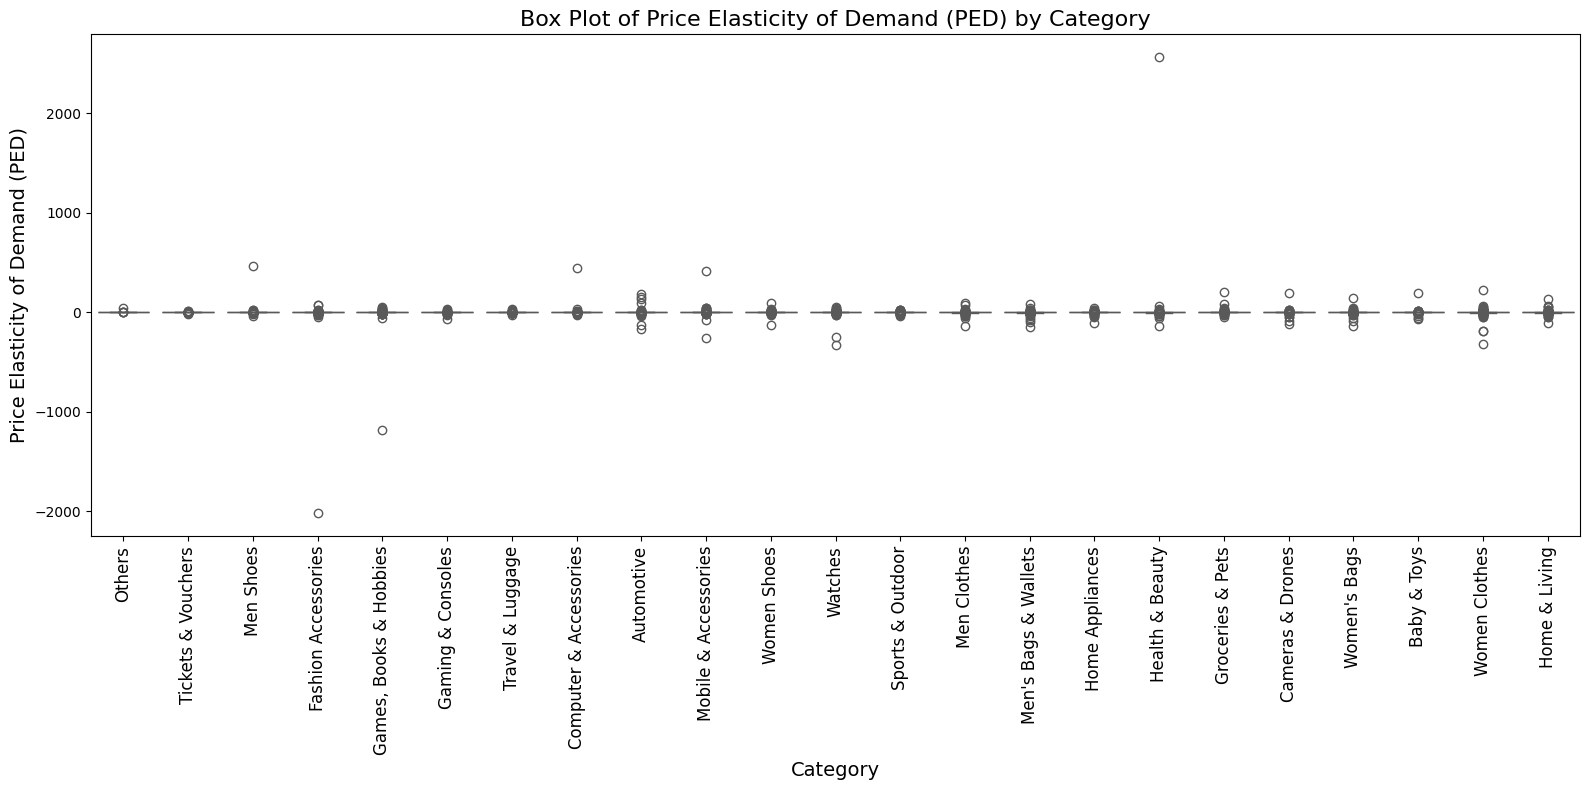

In [ ]:
# Calculate the median PED by category and sort it in descending order
average_ped_by_category = transformed_main_category.groupby("main_category")["PED"].median().sort_values(ascending=False)

# Reorder the categories based on median PED
ordered_categories = average_ped_by_category.index

# Create a box plot of PED by category using seaborn
plt.figure(figsize=(16, 8))  # Adjust figure size for better spacing
sns.boxplot(data=transformed_main_category, x="main_category", y="PED", hue='main_category', palette="Set2", order=ordered_categories)

# Title and labels
plt.title("Box Plot of Price Elasticity of Demand (PED) by Category", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Price Elasticity of Demand (PED)", fontsize=14)

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=90, fontsize=12)  # Rotate x-axis labels by 90 degrees

# Adjust layout to make sure nothing is cut off
plt.tight_layout()

# Show the plot
plt.show()


### Analysis of PED Range Across Categories

1. **Categories with Wide Range of PED Values**
   - **Interpretation**: Categories such as **Computer & Accessories**, **Health & Beauty**, and **Men Clothes** exhibit a wide range of PED values. This indicates that customer responses to price changes vary significantly within these categories, possibly due to diverse product types, brand loyalty variations, or distinct customer segments with differing levels of price sensitivity.
   - **Implications**: The diversity in PED within these categories suggests that some products are highly price-sensitive, while others are less affected by price changes.

   - **Strategic Insights**:
     - **Segmented Pricing**: Apply distinct pricing strategies within each category. For example, in **Men Clothes**, basic or lesser-known brands may require more aggressive discounting, while branded or premium products can maintain stable prices.
     - **Targeted Promotions**: Run targeted promotions on highly elastic products within these categories to drive demand, while keeping prices stable for less elastic items to maximize profit margins.
     - **Dynamic and Personalized Pricing**: Use dynamic or personalized pricing where feasible. For instance, offering discounts to price-sensitive segments within **Health & Beauty** (like basic skincare or grooming items) while maintaining regular prices on premium items can optimize revenue without over-discounting.

2. **Categories with Narrow Range of PED Values**
   - **Interpretation**: Categories such as **Gaming & Consoles**, **Watches**, and **Automotive** have a narrow range of PED values, indicating consistent price sensitivity across products within these categories. This could be due to uniform product characteristics, strong brand loyalty, or a perception of stability across these categories.
   - **Implications**: A narrow PED range suggests that customer demand patterns are more predictable, and customers are less likely to change purchasing behavior dramatically with minor price adjustments.

   - **Strategic Insights**:
     - **Consistent Pricing**: Maintain stable pricing across products within these categories. In **Gaming & Consoles**, for example, consistent pricing reinforces customer trust and aligns with uniform demand sensitivity, minimizing the need for frequent adjustments.
     - **Inventory-Linked Adjustments**: Given the stable demand response, pricing adjustments should primarily focus on inventory levels rather than dynamic pricing. For example, maintaining steady prices for **Watches** can aid in predictable inventory planning, reducing risks of overstock or stockouts.

### Comparing Pricing Strategies for Wide vs. Narrow PED Ranges

- **Categories with Wide PED Ranges**: Due to the significant variation in price sensitivity, these categories benefit from **flexible, adaptive pricing strategies**. Regular targeted discounts, dynamic pricing, and personalized offers can appeal to highly price-sensitive customers without affecting the less elastic products. Pricing adjustments may be needed more frequently based on demand shifts and inventory levels.

- **Categories with Narrow PED Ranges**: Categories like **Gaming & Consoles** and **Automotive**, with a narrower range of PED range, are better suited for **predictable and stable pricing strategies**. Rather than frequent changes, the focus should be on maintaining value perception, using occasional minor promotions only when necessary, which can reinforce brand value and customer loyalty.

---


In [ ]:
transformed_main_category

,main_category,order_time,avg_checkout_price,avg_additional_discount,day_of_week,week,month,is_weekend,products_discounted_percentage,campaign_percentage,avg_discount_percentage,daily_sales,time_period,previous_sales,previous_price,%_change_in_sales,%_change_in_price,PED,transformed_PED
0,Automotive,2019-01-01,0.850155,0.000000,1.0,1.0,1.0,0.0,50.000000,0.0,33.561111,6,2019-01-01,NaN,NaN,0.000000,0.000000,NaN,0.003549
1,Automotive,2019-01-02,0.284942,0.000000,2.0,1.0,1.0,0.0,50.000000,0.0,17.500000,2,2019-01-02,6.0,0.850155,-66.666667,-66.483516,1.002755,0.055541
2,Automotive,2019-01-03,0.663930,0.000000,3.0,1.0,1.0,0.0,60.000000,0.0,40.823333,5,2019-01-03,2.0,0.284942,150.000000,133.005464,1.127773,0.061941
3,Automotive,2019-01-04,11.918405,0.000000,4.0,1.0,1.0,0.0,42.857143,0.0,21.636221,14,2019-01-04,5.0,0.663930,180.000000,1695.128652,0.106187,0.009125
4,Automotive,2019-01-05,3.698537,0.000000,5.0,1.0,1.0,1.0,33.333333,0.0,12.947799,9,2019-01-05,14.0,11.918405,-35.714286,-68.967856,0.517840,0.030565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8385,Women's Bags,2019-12-27,16.459904,0.000000,4.0,4.0,12.0,0.0,57.142857,0.0,32.381099,7,2019-12-27,2.0,1.835774,250.000000,796.619411,0.313826,0.070938
8386,Women's Bags,2019-12-28,24.550307,0.000000,5.0,4.0,12.0,1.0,63.636364,0.0,44.027600,11,2019-12-28,7.0,16.459904,57.142857,49.152188,1.162570,0.138017
8387,Women's Bags,2019-12-29,20.091368,0.000000,6.0,4.0,12.0,1.0,90.000000,0.0,54.424760,10,2019-12-29,11.0,24.550307,-9.090909,-18.162456,0.500533,0.085654
8388,Women's Bags,2019-12-30,34.725553,0.000000,0.0,4.0,12.0,0.0,33.333333,0.0,18.153775,6,2019-12-30,10.0,20.091368,-40.000000,72.838167,-0.549163,0.003326



## **Develop a dynamic pricing model based on demand and competition**

#### **Updating products table with PED value**

In [ ]:
# Step 1: Creating a products table with PED, fill those without PED by the average of mid_category first, if still missing than fill by main_category 
mid_category_average_PED = final_df.groupby(['main_category', 'mid_category']).agg(PED_mean=('PED', 'mean')).reset_index()
main_category_average_PED = final_df.groupby(['main_category']).agg(PED_mean=('PED', 'mean')).reset_index()
products_df_with_PED = pd.merge(products_df, final_df[['product_id', 'PED']], on='product_id', how='left')

# First merge with mid_category_average_PED to fill missing PED values by (main_category, mid_category)
products_df_with_PED = pd.merge(products_df_with_PED, 
                                 mid_category_average_PED[['main_category', 'mid_category', 'PED_mean']], 
                                 on=['main_category', 'mid_category'], 
                                 how='left')

# Fill missing PED values with PED_mean from the mid-category merge
products_df_with_PED['PED'] = products_df_with_PED['PED'].fillna(products_df_with_PED['PED_mean'])

# Drop the 'PED_mean' column as it is no longer needed
products_df_with_PED = products_df_with_PED.drop(columns=['PED_mean'])

# Now, for any remaining missing PED values, merge with main_category_average_PED
products_df_with_PED = pd.merge(products_df_with_PED, 
                                 main_category_average_PED[['main_category', 'PED_mean']], 
                                 on='main_category', 
                                 how='left')

# Fill remaining missing PED values with PED_mean from the main-category merge
products_df_with_PED['PED'] = products_df_with_PED['PED'].fillna(products_df_with_PED['PED_mean'])

# Drop the 'PED_mean' column as it is no longer needed
products_df_with_PED = products_df_with_PED.drop(columns=['PED_mean'])


NameError: name 'final_df' is not defined

#### **Data Preperation for Dynamic Pricing**

In [ ]:
# Step 2: Create the product_sales DataFrame
product_sales = merged_df.groupby('product_id').size().reset_index(name='quantity_sold')

# Step 3: Left join with products_df on 'product_id'
product_sales_full = pd.merge(products_df_with_PED, product_sales, on='product_id', how='inner')

# Step 4: Fill missing 'quantity_sold' with 0
product_sales_full['quantity_sold'] = product_sales_full['quantity_sold'].fillna(0)


In [ ]:
dynamic_final_df = product_sales_full[['product_id', 'price_actual', 'quantity_sold', 
                                'main_category', 'mid_category', 'sub_category', 
                                'seller_name','item_rating', 'favorite', 
                                'stock', 'shipped_from', 'PED']].rename(columns={
    'checkout_price': 'price',
    'quantity_sold': 'total_quantity'
})

dynamic_final_df

,product_id,price_actual,total_quantity,main_category,mid_category,sub_category,seller_name,item_rating,favorite,stock,shipped_from,PED
0,1,4.017215,1,Women's Bags,Shoulder Bags,Shoulder Bags,qqfwholesale,4.9,128.0,2906,Singapore,2.675449
1,2,0.700677,6,Home Appliances,Sewing Machines,Sewing Machines and Accessories,stationery.my,5.0,19.0,31701,China,2.757273
2,3,2.647002,8,Women's Bags,Handbags,Set Handbags,fooyin88,4.9,21500.0,2044,Malaysia,0.000000
3,3,2.647002,8,Women's Bags,Handbags,Set Handbags,fooyin88,4.9,21500.0,2044,Malaysia,0.000000
4,4,2.709284,12,Women Clothes,Maternity Wear,Innerwear,vivi2002,4.9,3400.0,386,Malaysia,2.222089
...,...,...,...,...,...,...,...,...,...,...,...,...
21797,20306,2.703056,6,Home Appliances,Irons & Garment Steamers,Steam Iron,elenxs.my,4.9,324.0,912,China,6.000000
21798,20308,9.454468,3,Baby & Toys,Girls Fashion,Girl Shoes,amour.my,4.9,1600.0,19076,Singapore,2.031106
21799,20309,9.965184,4,Baby & Toys,Girls Fashion,Girl Dresses,mazu9,4.8,304.0,9406,Malaysia,2.031106
21800,20311,1.868472,6,Baby & Toys,Others,Others,pbs_empire,4.9,27.0,3695,Singapore,3.033513


In [ ]:
dynamic_final_df[dynamic_final_df.sub_category == 'Occupational Attire'].PED.mean()

2.1082043885750994

### **Finding the demand and competition of each product**

#### **1. demand_index**

**Description**:  
The `demand_index` classifies products into three categories: **Low**, **Medium**, or **High** demand, based solely on their price relative to the mean price within each product's `main_category` and `mid_category`.

**How it works**:  
- **Low**: Products with a total quantity sold below the 33rd percentile of the `total_quantity` within their respective `main_category` and `mid_category`.
- **Medium**: Products with a total quantity sold between the 33rd and 66th percentiles of the `total_quantity` within their respective `main_category` and `mid_category`.
- **High**: Products with a total quantity sold above the 66th percentile of the `total_quantity` within their respective `main_category` and `mid_category`.

#### **2. competition_index**

**Description**:  
The `competition_index` classifies products into three competition levels: **Low**, **Medium**, or **High**, based on the normalized price and stock levels within each product's `main_category` and `mid_category`.

**How it works**:  
- **Low**: Products whose prices are **further from the mean price** (either significantly higher or lower than most products in the category). These products are considered to face **low competition** because they are priced outside the typical range, making them less comparable to other products in the category.
- **Medium**: Products with prices that are **closer to the mean price**, but not the closest. These products are considered to face **medium competition**, as their prices are more in line with the category average but not quite as competitive as those that are the closest to the mean.
- **High**: Products whose prices are **closest to the mean price** within their category. These products face **high competition** because their prices are more in line with the typical price point of the category, making them more directly comparable to other products and thus more susceptible to competition.




In [ ]:
def demand_category(row, quantiles):
    # Low demand
    if row['total_quantity'] < quantiles[0]:  
        return 'Low'
    # Medium demand
    elif row['total_quantity'] < quantiles[1]:  
        return 'Medium'
    # High demand
    else:  
        return 'High'

# Iterate through each group (by 'main_category' and 'mid_category') and apply demand categorization
def assign_demand_index(df):
    demand_indices = []  # To store the demand index for each product
    for _, group in df.groupby(['main_category', 'mid_category']):
        # Calculate the quantiles (33rd and 66th) for the total_quantity in the current group
        quantiles = group['total_quantity'].quantile([0.33, 0.66]).values
        
        # Apply the demand_category function to each row in the group
        group['demand_index'] = group.apply(demand_category, quantiles=quantiles, axis=1)
        
        # Append the group back to the list of dataframes with the demand index
        demand_indices.append(group)
    
    # Concatenate all groups back together
    return pd.concat(demand_indices)

# Assign the demand index to each product
dynamic_final_df = assign_demand_index(dynamic_final_df)

In [ ]:
# Function to calculate competition score based on price (mean-based)
def calculate_price_based_competition_score(group):
    # Calculate the mean price for the group
    mean_price = group['checkout_price'].mean()
    
    # Calculate the absolute difference between each product price and the mean price
    group['price_difference'] = np.abs(group['checkout_price'] - mean_price)
    
    # Normalize the price difference by the range (max - min), not just max
    price_range = group['checkout_price'].max() - group['checkout_price'].min()
    
    # Prevent division by zero if all prices are the same
    if price_range == 0:
        group['competition_score'] = 1
    else:
        group['competition_score'] = 1 - (group['price_difference'] / price_range)
    
    return group

# Function to assign competition index based on price (mean-based) using custom quantiles
def assign_price_based_competition_index(df):
    competition_indices = []  # To store the competition index for each product
    
    # Group by categories
    for _, group in df.groupby(['main_category', 'mid_category']):
        # Calculate competition score based on price (relative to the mean price)
        group = calculate_price_based_competition_score(group)
        
        # Compute quantiles (33% and 66%)
        quantiles = group['competition_score'].quantile([0.33, 0.66]).values
        
        # Categorize competition based on the quantiles
        group['competition_index'] = group['competition_score'].apply(lambda x: competition_category(x, quantiles))
        
        # Append the group back to the list of dataframes with the competition index
        competition_indices.append(group)
    
    # Concatenate all groups back together
    return pd.concat(competition_indices)

# Function to categorize competition based on quantiles
def competition_category(row, quantiles):
    # Low competition (score is below 33rd percentile)
    if row > quantiles[1]:
        return 'High'  # Price closer to the mean = high competition
    # Medium competition (score is between 33rd and 66th percentile)
    elif row > quantiles[0]:
        return 'Medium'
    # Low competition (score is below 33rd percentile -> price further from the mean)
    else:
        return 'Low'

# Apply the new competition index calculation based on price
dynamic_final_df = assign_price_based_competition_index(dynamic_final_df)



KeyError: 'checkout_price'



### **Dynamic Pricing Model**

**Overview:**  
This dynamic pricing model adjusts product prices based on three key factors to optimize revenue in real-time:
1. **Demand Index**: Reflects the demand level for a product (Low, Medium, High).
2. **Competition Index**:  Reflects the price competitiveness of a product within its category (Low, Medium, High).
3. **Price Elasticity of Demand (PED)**: Measures how sensitive demand is to price changes (absolute value).

The model dynamically adjusts prices by evaluating these factors to ensure competitive pricing and revenue maximization.

### **Price Adjustment Logic:**
- The price adjustments are now based on a combination of the **Demand Index**, **Competition Index**, and **Price Elasticity of Demand (PED)**.
- The final price adjustment is calculated as a weighted sum of these three factors:
    - **Demand Adjustment**:  
      - **Low Demand**: Decrease by 3%.
      - **Medium Demand**: No change.
      - **High Demand**: Increase by 3%.
    - **Competition Adjustment**:  
      - **High Competition**: Decrease by 3%.
      - **Medium Competition**: No change.
      - **Low Competition**: Increase by 3%.
    - **PED Adjustment**:  
      - **High PED (Elastic Demand, PED > 1)**: Adjust by ±2%.
      - **Unitary PED (PED = 1)**: No change.
      - **Low PED (Inelastic Demand, PED < 1)**: Adjust by ±2%.

The total price adjustment factor is the sum of these three adjustments. The final new price is then calculated as:

New Price = Original Price * (1 + Total Price Adjustment)



In [ ]:
# Assuming 'dynamic_final_df' is your original dataframe with PED, competition_index, and demand_index columns.

# Function to calculate price adjustment based on demand, competition, and PED (absolute values)
def calculate_price_adjustment(row):
    # Demand index adjustment
    if row['demand_index'] == 'Low':
        demand_adjustment = -0.03  # Decrease price by 3%
    elif row['demand_index'] == 'Medium':
        demand_adjustment = 0.00  # No change
    else:  # High demand
        demand_adjustment = 0.03  # Increase price by 3%

    # Competition index adjustment
    if row['competition_index'] == 'High':
        competition_adjustment = -0.03  # Decrease price by 3%
    elif row['competition_index'] == 'Medium':
        competition_adjustment = 0.00  # No change
    else:  # Low competition
        competition_adjustment = 0.03  # Increase price by 3%

    # Absolute PED adjustment
    abs_ped = abs(row['PED'])  # Use absolute value of PED for price adjustment
    
    # Adjusting based on the absolute PED value
    if abs_ped > 1:  # Elastic demand (PED > 1)
        ped_adjustment = -0.02  # Moderate price sensitivity (increase/decrease by 3%)
    elif abs_ped == 1:  # Unitary elasticity (PED = 1)
        ped_adjustment = 0.00  # No change in price
    else:  # Inelastic demand (PED < 1)
        ped_adjustment = +0.02  # Small price change (decrease by 2%)

    # Combine all adjustments to get the total price adjustment factor
    total_adjustment = demand_adjustment + competition_adjustment + ped_adjustment

    # Apply the adjustment to the current price
    new_price = row['price'] * (1 + total_adjustment)

    return new_price

# Apply the pricing adjustment function to the dataframe
dynamic_final_df['new_price'] = dynamic_final_df.apply(calculate_price_adjustment, axis=1)

# Create a new dataframe with product_id and the new price
pricing_df = dynamic_final_df[['product_id', 'price', 'new_price']].rename(columns={'price': 'old_price'})

# Show the result
print(pricing_df)

       product_id  old_price  new_price
1568         1612   3.114120   3.238685
3253         3346   8.137196   8.218568
4945         5106  62.282401  57.299809
5615         5817  15.414894  15.106596
6824         7095  21.487428  20.413057
...           ...        ...        ...
15760       16441  10.899420  10.354449
15774       16455   1.183366   1.195199
17513       18243  48.932168  47.953525
17614       18347  39.860737  36.671878
17667       18405  46.711801  48.580273

[19439 rows x 3 columns]




### **Dynamic Pricing Model: Maximizing Revenue**

The **dynamic pricing model** adjusts product prices in real-time based on three key factors: **Demand**, **Competition**, and **Price Elasticity**. Here's how it maximizes revenue:

- **Demand Index**:  
  - **High Demand**: Increase prices to capture higher revenue from strong market interest.  
  - **Low Demand**: Decrease prices to stimulate sales and move inventory.

- **Competition Index**:  
  - **High Competition**: Lower prices to stay competitive and attract price-sensitive customers.  
  - **Low Competition**: Increase prices to maximize revenue without losing market share.

- **Price Elasticity (PED)**:  
  - **Elastic Products**: Adjust prices more aggressively (up or down) to optimize sales and revenue.  
  - **Inelastic Products**: Raise prices slightly to maximize profit without losing customers.

### **Revenue Maximization**:  
- **Increase revenue per unit** by adjusting prices during high demand or in low competition.
- **Boost sales volume** by lowering prices during low demand or high competition.
- **Optimize profit** from inelastic products by leveraging less price sensitivity.

By adjusting prices based on these factors, the model ensures products are always optimally priced for current market conditions, maximizing revenue and profitability.

---